In [1]:
import os
import numpy as np
import pandas as pd
import time
import glob
import pathlib
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
from plotnine import *
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, mean_squared_error

import sys
sys.path.append("/tf/model/vggish")

import vggish_params 
import vggish_input
import mel_features

seed = 27
tf.random.set_seed(seed)
random.seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [2]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [3]:
EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 200

BATCH_SIZE=32
DROPOUT=0.3
LEARNING_RATE=0.001
CLASSIFICATION_RATIO=0.999

In [4]:
data_path = '/tf/data/ADReSS-IS2020'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [5]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))
meta.ID = meta.ID.str.strip()
meta.Gender = meta.Gender.str.strip()

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
size_sec = 30
stride_sec = 1

In [8]:
def window(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range((length-size)//stride+1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0]
    mmse = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    group = tf.gather(meta.Group.map({'cc': 0, 'cd': 1}), tf.where(tf.equal(names, name))[0][0])
    
    age = tf.gather(meta.Age, tf.where(tf.equal(names, name))[0][0])
    gender = tf.gather(meta.Gender.map({'male': 0, 'female': 1}), tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
#     waveform = decode_audio(audio_binary)
        
    rolling_waveform_tensors = window(waveform, size=int(_*size_sec), stride=int(_*stride_sec))
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, age, gender, mmse, group

In [9]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .cache()\
                        .prefetch(100)\
                        .flat_map(lambda spec, age, gender, mmse, group: tf.data.Dataset.zip((
                                    tf.data.Dataset.zip((
                                        tf.data.Dataset.from_tensor_slices(spec), 
                                        tf.data.Dataset.from_tensor_slices([age]),
                                        tf.data.Dataset.from_tensor_slices([gender]),
                                    )),
                                    tf.data.Dataset.zip((
                                        tf.data.Dataset.from_tensor_slices([mmse]), 
                                        tf.data.Dataset.from_tensor_slices([group]) 
                                    ))
                                )))\
                        .shuffle(100)
    return output_ds

In [10]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Instructions for updating:
Use fn_output_signature instead


In [11]:
for input, output in train_ds.take(1):
    input_shape = input[0].shape
    print(input_shape)
    print(input[1])
    print(input[2])
    print(output[0])
    print(output[1])


(30, 257, 1)
tf.Tensor(57, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(30, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


In [12]:
train_ds_b = train_ds.batch(BATCH_SIZE)
val_ds_b = val_ds.batch(BATCH_SIZE)

In [13]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x[0]))

In [14]:
specInput = layers.Input(shape=input_shape)
reshapeSpecInput = layers.Reshape((input_shape[0],input_shape[1]))(specInput)
normSpec = norm_layer(reshapeSpecInput)

ageInput = layers.Input(shape=(1,))
genderInput = layers.Input(shape=(1,))


dense1 = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(normSpec)
dropout1 = layers.Dropout(0.25)(dense1)
lstm1 = layers.LSTM(128, activation='relu', kernel_initializer='he_normal', return_sequences=True)(dropout1)
dropout2 = layers.Dropout(0.25)(lstm1)
lstm2 = layers.LSTM(64, activation='relu', kernel_initializer='he_normal')(dropout2)
dropout3 = layers.Dropout(0.25)(lstm2)

concat = tf.keras.layers.Concatenate()([dropout3, ageInput, genderInput])

dense2 = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(concat)
dropout4 = layers.Dropout(0.25)(dense2)

mmseDense = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(dropout4)
mmse = layers.Dense(1, activation='relu', name='mmse')(mmseDense)

classificationDense = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(dropout4)
classification = layers.Dense(1, activation='sigmoid', name='classification')(classificationDense)

model = tf.keras.Model(
    inputs=[specInput, ageInput, genderInput],
    outputs=[mmse, classification],
)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 257, 1)] 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 30, 257)      0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 30, 257)      3           reshape[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 30, 256)      66048       normalization[0][0]              
______________________________________________________________________________________________

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0),
    loss = ['mse','binary_crossentropy'],
    loss_weights=[1-CLASSIFICATION_RATIO, CLASSIFICATION_RATIO]
)

In [16]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(SquareRootScheduler(lr=LEARNING_RATE))

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=EARLY_STOPPING_PATIENCE, 
    restore_best_weights=True)

history = model.fit(
    train_ds_b, 
    validation_data=val_ds_b,  
    epochs=EPOCHS,
    callbacks=[lr_callback, es_callback]
)

Epoch 1/1000
3/3 [==============================] - 4s 870ms/step - loss: 7.4468 - mmse_loss: 575.3916 - classification_loss: 6.8783 - val_loss: 2.4992 - val_mmse_loss: 626.1811 - val_classification_loss: 1.8749
Epoch 2/1000
3/3 [==============================] - 0s 107ms/step - loss: 5.6788 - mmse_loss: 488.4974 - classification_loss: 5.1955 - val_loss: 1.6334 - val_mmse_loss: 584.8372 - val_classification_loss: 1.0496
Epoch 3/1000
3/3 [==============================] - 0s 111ms/step - loss: 4.3892 - mmse_loss: 446.2335 - classification_loss: 3.9469 - val_loss: 1.7717 - val_mmse_loss: 573.8871 - val_classification_loss: 1.1990
Epoch 4/1000
3/3 [==============================] - 0s 104ms/step - loss: 4.1744 - mmse_loss: 414.6406 - classification_loss: 3.7635 - val_loss: 2.1143 - val_mmse_loss: 514.2704 - val_classification_loss: 1.6016
Epoch 5/1000
3/3 [==============================] - 0s 106ms/step - loss: 2.9176 - mmse_loss: 386.9886 - classification_loss: 2.5332 - val_loss: 2.7011 

3/3 [==============================] - 0s 102ms/step - loss: 1.8334 - mmse_loss: 105.7700 - classification_loss: 1.7294 - val_loss: 1.0963 - val_mmse_loss: 136.0543 - val_classification_loss: 0.9613
Epoch 40/1000
3/3 [==============================] - 0s 104ms/step - loss: 2.4134 - mmse_loss: 144.8692 - classification_loss: 2.2708 - val_loss: 1.1149 - val_mmse_loss: 122.1113 - val_classification_loss: 0.9938
Epoch 41/1000
3/3 [==============================] - 0s 103ms/step - loss: 1.2865 - mmse_loss: 117.7643 - classification_loss: 1.1699 - val_loss: 1.1459 - val_mmse_loss: 113.3784 - val_classification_loss: 1.0335
Epoch 42/1000
3/3 [==============================] - 0s 101ms/step - loss: 2.1575 - mmse_loss: 185.9905 - classification_loss: 1.9735 - val_loss: 1.1534 - val_mmse_loss: 115.1324 - val_classification_loss: 1.0393
Epoch 43/1000
3/3 [==============================] - 0s 103ms/step - loss: 2.1557 - mmse_loss: 129.2056 - classification_loss: 2.0286 - val_loss: 1.1793 - val_mms

Epoch 78/1000
3/3 [==============================] - 0s 114ms/step - loss: 1.5129 - mmse_loss: 116.3513 - classification_loss: 1.3979 - val_loss: 0.5178 - val_mmse_loss: 96.4631 - val_classification_loss: 0.4218
Epoch 79/1000
3/3 [==============================] - 0s 107ms/step - loss: 1.3306 - mmse_loss: 158.4496 - classification_loss: 1.1733 - val_loss: 0.4583 - val_mmse_loss: 85.9573 - val_classification_loss: 0.3727
Epoch 80/1000
3/3 [==============================] - 0s 104ms/step - loss: 1.8487 - mmse_loss: 101.2848 - classification_loss: 1.7492 - val_loss: 0.4483 - val_mmse_loss: 81.3813 - val_classification_loss: 0.3673
Epoch 81/1000
3/3 [==============================] - 0s 107ms/step - loss: 1.6615 - mmse_loss: 130.5290 - classification_loss: 1.5325 - val_loss: 0.5127 - val_mmse_loss: 83.0725 - val_classification_loss: 0.4300
Epoch 82/1000
3/3 [==============================] - 0s 103ms/step - loss: 1.2051 - mmse_loss: 107.2339 - classification_loss: 1.0990 - val_loss: 0.4880

3/3 [==============================] - 0s 101ms/step - loss: 1.9476 - mmse_loss: 104.5024 - classification_loss: 1.8449 - val_loss: 0.8589 - val_mmse_loss: 88.3829 - val_classification_loss: 0.7713
Epoch 117/1000
3/3 [==============================] - 0s 101ms/step - loss: 1.1513 - mmse_loss: 108.4979 - classification_loss: 1.0438 - val_loss: 0.8498 - val_mmse_loss: 88.4854 - val_classification_loss: 0.7621
Epoch 118/1000
3/3 [==============================] - 0s 100ms/step - loss: 1.2897 - mmse_loss: 120.1101 - classification_loss: 1.1708 - val_loss: 0.8308 - val_mmse_loss: 88.8128 - val_classification_loss: 0.7427
Epoch 119/1000
3/3 [==============================] - 0s 104ms/step - loss: 1.0957 - mmse_loss: 88.3531 - classification_loss: 1.0084 - val_loss: 0.8086 - val_mmse_loss: 88.6496 - val_classification_loss: 0.7207
Epoch 120/1000
3/3 [==============================] - 0s 101ms/step - loss: 1.3901 - mmse_loss: 129.6153 - classification_loss: 1.2617 - val_loss: 0.7733 - val_mmse

Epoch 155/1000
3/3 [==============================] - 0s 103ms/step - loss: 1.2635 - mmse_loss: 108.7118 - classification_loss: 1.1559 - val_loss: 0.4630 - val_mmse_loss: 90.1681 - val_classification_loss: 0.3732
Epoch 156/1000
3/3 [==============================] - 0s 95ms/step - loss: 1.1025 - mmse_loss: 120.9098 - classification_loss: 0.9825 - val_loss: 0.5219 - val_mmse_loss: 91.4269 - val_classification_loss: 0.4309
Epoch 157/1000
3/3 [==============================] - 0s 96ms/step - loss: 1.2376 - mmse_loss: 122.7619 - classification_loss: 1.1160 - val_loss: 0.6645 - val_mmse_loss: 93.3060 - val_classification_loss: 0.5718
Epoch 158/1000
3/3 [==============================] - 0s 101ms/step - loss: 0.8706 - mmse_loss: 135.5537 - classification_loss: 0.7358 - val_loss: 0.7087 - val_mmse_loss: 91.9501 - val_classification_loss: 0.6174
Epoch 159/1000
3/3 [==============================] - 0s 102ms/step - loss: 1.3296 - mmse_loss: 92.8924 - classification_loss: 1.2379 - val_loss: 0.71

Epoch 194/1000
3/3 [==============================] - 0s 102ms/step - loss: 1.0097 - mmse_loss: 113.8895 - classification_loss: 0.8968 - val_loss: 0.7757 - val_mmse_loss: 90.0622 - val_classification_loss: 0.6863
Epoch 195/1000
3/3 [==============================] - 0s 98ms/step - loss: 0.9135 - mmse_loss: 83.3410 - classification_loss: 0.8310 - val_loss: 0.7951 - val_mmse_loss: 90.4922 - val_classification_loss: 0.7053
Epoch 196/1000
3/3 [==============================] - 0s 101ms/step - loss: 0.8930 - mmse_loss: 91.5020 - classification_loss: 0.8023 - val_loss: 0.5557 - val_mmse_loss: 83.9663 - val_classification_loss: 0.4722
Epoch 197/1000
3/3 [==============================] - 0s 104ms/step - loss: 0.8889 - mmse_loss: 100.9634 - classification_loss: 0.7887 - val_loss: 0.4311 - val_mmse_loss: 80.5571 - val_classification_loss: 0.3509
Epoch 198/1000
3/3 [==============================] - 0s 102ms/step - loss: 0.7822 - mmse_loss: 115.1282 - classification_loss: 0.6677 - val_loss: 0.43

Epoch 233/1000
3/3 [==============================] - 0s 103ms/step - loss: 1.1145 - mmse_loss: 103.1051 - classification_loss: 1.0124 - val_loss: 0.5033 - val_mmse_loss: 87.6058 - val_classification_loss: 0.4161
Epoch 234/1000
3/3 [==============================] - 0s 103ms/step - loss: 1.5247 - mmse_loss: 78.3685 - classification_loss: 1.4478 - val_loss: 0.4869 - val_mmse_loss: 86.1342 - val_classification_loss: 0.4011
Epoch 235/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.7463 - mmse_loss: 76.4496 - classification_loss: 0.6705 - val_loss: 0.5133 - val_mmse_loss: 87.9718 - val_classification_loss: 0.4258
Epoch 236/1000
3/3 [==============================] - 0s 99ms/step - loss: 0.9708 - mmse_loss: 78.4777 - classification_loss: 0.8933 - val_loss: 0.5154 - val_mmse_loss: 88.5291 - val_classification_loss: 0.4273
Epoch 237/1000
3/3 [==============================] - 0s 102ms/step - loss: 0.7889 - mmse_loss: 91.3810 - classification_loss: 0.6982 - val_loss: 0.4819 

Epoch 272/1000
3/3 [==============================] - 0s 139ms/step - loss: 1.1201 - mmse_loss: 102.6272 - classification_loss: 1.0185 - val_loss: 0.5009 - val_mmse_loss: 81.0963 - val_classification_loss: 0.4203
Epoch 273/1000
3/3 [==============================] - 0s 98ms/step - loss: 1.0208 - mmse_loss: 77.6342 - classification_loss: 0.9441 - val_loss: 0.5038 - val_mmse_loss: 81.7941 - val_classification_loss: 0.4225
Epoch 274/1000
3/3 [==============================] - 0s 97ms/step - loss: 0.9633 - mmse_loss: 107.4362 - classification_loss: 0.8567 - val_loss: 0.4673 - val_mmse_loss: 77.2506 - val_classification_loss: 0.3905
Epoch 275/1000
3/3 [==============================] - 0s 105ms/step - loss: 0.8390 - mmse_loss: 75.3896 - classification_loss: 0.7644 - val_loss: 0.4342 - val_mmse_loss: 72.0095 - val_classification_loss: 0.3625
Epoch 276/1000
3/3 [==============================] - 0s 97ms/step - loss: 0.8449 - mmse_loss: 82.0940 - classification_loss: 0.7636 - val_loss: 0.4186 

Epoch 311/1000
3/3 [==============================] - 0s 97ms/step - loss: 1.0653 - mmse_loss: 119.1546 - classification_loss: 0.9471 - val_loss: 0.4002 - val_mmse_loss: 78.6065 - val_classification_loss: 0.3219
Epoch 312/1000
3/3 [==============================] - 0s 99ms/step - loss: 0.7912 - mmse_loss: 94.1078 - classification_loss: 0.6978 - val_loss: 0.4543 - val_mmse_loss: 83.7449 - val_classification_loss: 0.3709
Epoch 313/1000
3/3 [==============================] - 0s 98ms/step - loss: 0.7270 - mmse_loss: 52.0655 - classification_loss: 0.6756 - val_loss: 0.6038 - val_mmse_loss: 92.7250 - val_classification_loss: 0.5116
Epoch 314/1000
3/3 [==============================] - 0s 106ms/step - loss: 0.7596 - mmse_loss: 80.7562 - classification_loss: 0.6796 - val_loss: 0.7057 - val_mmse_loss: 97.4857 - val_classification_loss: 0.6089
Epoch 315/1000
3/3 [==============================] - 0s 102ms/step - loss: 0.7748 - mmse_loss: 104.6933 - classification_loss: 0.6708 - val_loss: 0.6937 

Epoch 350/1000
3/3 [==============================] - 0s 97ms/step - loss: 0.8603 - mmse_loss: 96.1068 - classification_loss: 0.7649 - val_loss: 0.4219 - val_mmse_loss: 69.6237 - val_classification_loss: 0.3526
Epoch 351/1000
3/3 [==============================] - 0s 97ms/step - loss: 0.7301 - mmse_loss: 97.5635 - classification_loss: 0.6331 - val_loss: 0.4361 - val_mmse_loss: 70.5379 - val_classification_loss: 0.3659
Epoch 352/1000
3/3 [==============================] - 0s 100ms/step - loss: 0.8947 - mmse_loss: 82.0215 - classification_loss: 0.8135 - val_loss: 0.4387 - val_mmse_loss: 71.8748 - val_classification_loss: 0.3672
Epoch 353/1000
3/3 [==============================] - 0s 97ms/step - loss: 0.9890 - mmse_loss: 88.2928 - classification_loss: 0.9016 - val_loss: 0.4462 - val_mmse_loss: 73.6619 - val_classification_loss: 0.3730
Epoch 354/1000
3/3 [==============================] - 0s 99ms/step - loss: 0.8096 - mmse_loss: 95.6867 - classification_loss: 0.7147 - val_loss: 0.4514 - v

Epoch 389/1000
3/3 [==============================] - 0s 104ms/step - loss: 0.5751 - mmse_loss: 91.7960 - classification_loss: 0.4838 - val_loss: 0.5640 - val_mmse_loss: 84.4355 - val_classification_loss: 0.4800
Epoch 390/1000
3/3 [==============================] - 0s 102ms/step - loss: 0.7040 - mmse_loss: 78.3553 - classification_loss: 0.6263 - val_loss: 0.5898 - val_mmse_loss: 86.6637 - val_classification_loss: 0.5036
Epoch 391/1000
3/3 [==============================] - 0s 102ms/step - loss: 0.7304 - mmse_loss: 99.8741 - classification_loss: 0.6311 - val_loss: 0.6197 - val_mmse_loss: 88.3565 - val_classification_loss: 0.5319
Epoch 392/1000
3/3 [==============================] - 0s 103ms/step - loss: 0.6645 - mmse_loss: 112.9137 - classification_loss: 0.5521 - val_loss: 0.5674 - val_mmse_loss: 84.1601 - val_classification_loss: 0.4837
Epoch 393/1000
3/3 [==============================] - 0s 99ms/step - loss: 0.6120 - mmse_loss: 70.5334 - classification_loss: 0.5420 - val_loss: 0.5296

Epoch 428/1000
3/3 [==============================] - 0s 106ms/step - loss: 0.6315 - mmse_loss: 101.9434 - classification_loss: 0.5300 - val_loss: 0.6545 - val_mmse_loss: 93.0852 - val_classification_loss: 0.5620
Epoch 429/1000
3/3 [==============================] - 0s 98ms/step - loss: 0.7120 - mmse_loss: 82.0211 - classification_loss: 0.6306 - val_loss: 0.6799 - val_mmse_loss: 89.9872 - val_classification_loss: 0.5905
Epoch 430/1000
3/3 [==============================] - 0s 105ms/step - loss: 0.5374 - mmse_loss: 85.8243 - classification_loss: 0.4520 - val_loss: 0.6936 - val_mmse_loss: 88.1754 - val_classification_loss: 0.6060
Epoch 431/1000
3/3 [==============================] - 0s 106ms/step - loss: 0.7565 - mmse_loss: 113.1259 - classification_loss: 0.6440 - val_loss: 0.6814 - val_mmse_loss: 86.4702 - val_classification_loss: 0.5955
Epoch 432/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.6622 - mmse_loss: 86.2613 - classification_loss: 0.5765 - val_loss: 0.6722

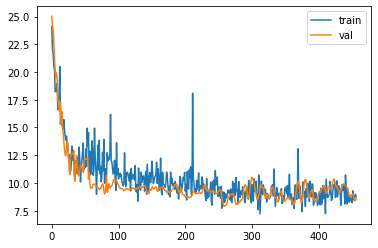

In [17]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mmse_loss']), np.sqrt(metrics['val_mmse_loss']))
plt.legend(['train', 'val'])
plt.show()

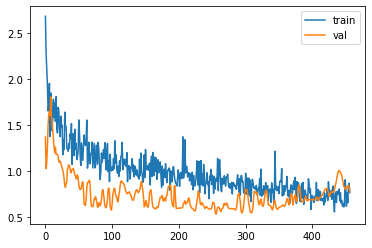

In [18]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['classification_loss']), np.sqrt(metrics['val_classification_loss']))
plt.legend(['train', 'val'])
plt.show()

In [19]:
model.predict(preprocess_dataset([train_files[2]]).batch(1))[0].flatten()[0]

16.682861

In [20]:
meta = meta.assign(split = '', predict_mmse = -99.99, predict_group_prob = 0)

def applyModelStats(file, split_type):
    
    id = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    
    meta.loc[meta["ID"]==id,'split'] = split_type
    predict = model.predict(preprocess_dataset([file]).batch(1))
    
    mmse = predict[0].flatten()[0]
    group_prob = predict[1].flatten()[0]
    
    median_predict = np.percentile(predict[0].flatten()[0], 50)   
    predict25 = np.percentile(predict[0].flatten()[0], 25)   
    predict75 = np.percentile(predict[0].flatten()[0], 75)   
    
    avg_predict_group_prob = np.median(predict[1][:,0])
    std_predict_group_prob = np.std(predict[1][:,0])
    
    meta.loc[meta["ID"]==id,'predict_mmse'] = mmse    
    meta.loc[meta["ID"]==id,'predict_group_prob'] = group_prob


for file in train_files:
    applyModelStats(file, "train")
    
for file in val_files:
    applyModelStats(file, "val")
    
for file in test_files:
    applyModelStats(file, "test")

In [21]:
meta

,index,ID,Age,Gender,MMSE,Group,split,predict_mmse,predict_group_prob
0,0,S001,74,male,30,cc,train,25.081205,0.027883
1,1,S002,62,female,30,cc,train,18.293940,0.216480
2,2,S003,69,female,29,cc,train,31.432690,0.000029
3,3,S004,71,female,30,cc,test,28.395407,0.002509
4,4,S005,74,female,30,cc,val,22.318474,0.162713
...,...,...,...,...,...,...,...,...,...
103,49,S150,58,male,20,cd,train,19.098625,0.466234
104,50,S151,72,male,24,cd,train,13.419196,1.000000
105,51,S153,68,female,12,cd,val,14.659718,0.963745
106,52,S154,65,female,20,cd,train,13.369176,0.999345


In [22]:
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
def cal_rmse(g):
    rmse = np.sqrt(mean_squared_error(g['MMSE'], g['predict_mmse'] ) )
    return pd.Series(dict(rmse = rmse ))

meta.groupby('split').apply(cal_rmse).reset_index()

,split,rmse
0,test,8.838049
1,train,5.961272
2,val,8.282809


In [23]:
meta.groupby('Gender').apply(cal_rmse).reset_index()

,Gender,rmse
0,female,6.687754
1,male,7.081758


In [24]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict_mmse'] ))

6.865658669209108

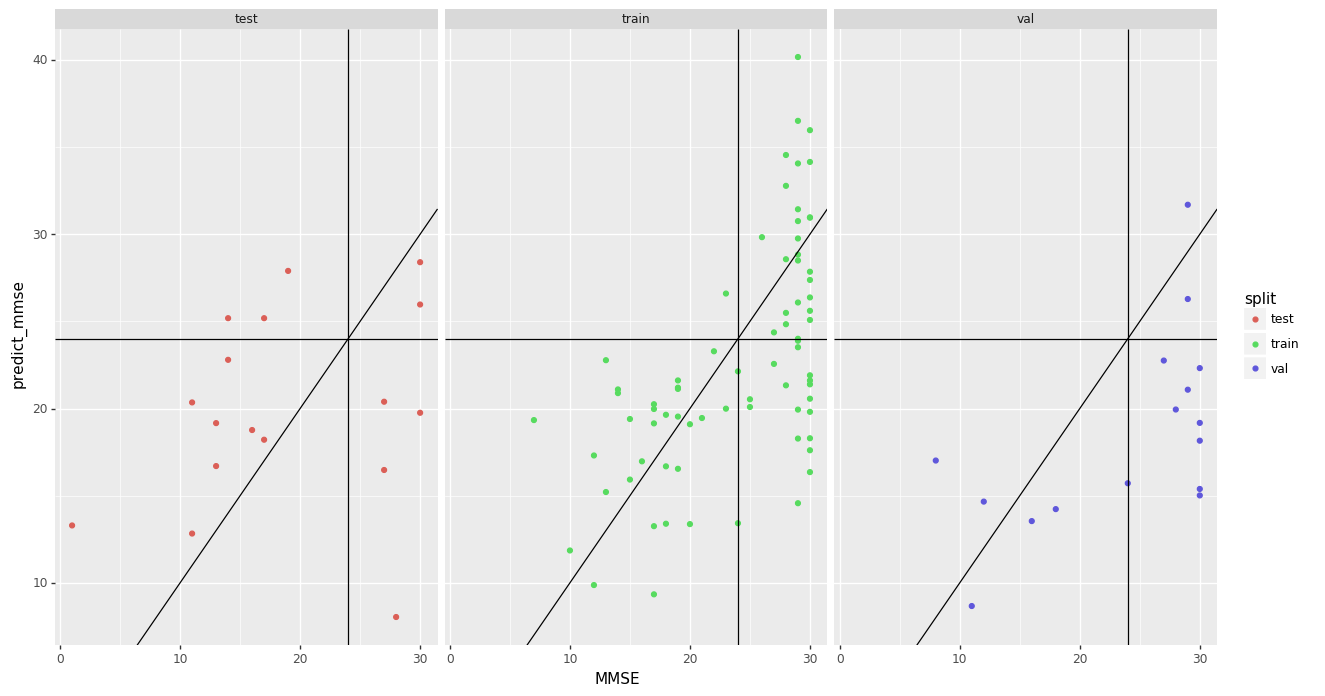

<ggplot: (8762652154039)>

In [25]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict_mmse', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

Logistic: ROC AUC = 0.843


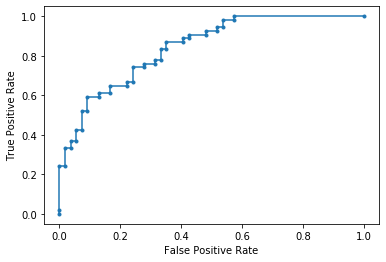

In [26]:
y = meta.Group.apply(lambda x: 1 if x=="cd" else 0)
probs = meta.predict_group_prob

lr_auc = roc_auc_score(y, probs)

# summarize scores
print('Logistic: ROC AUC = %.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the plot
plt.show()

In [27]:
# model.save('saved_model/base_line/20210222')

In [28]:
ls saved_model/base_line

20210210/  20210217/  20210222/  20210225/
